In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sci
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,learning_curve
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost 
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_squared_error


In [3]:
df = pd.read_excel('Capstone Project.xlsx')

In [4]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [5]:
df.tail()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,270,55.06
1029,540.0,0.0,0.0,173.0,0.0,1125.0,613.0,7,52.61


In [6]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


### Analysis
- As each column has a count of 1030, this dataset does not have any missing values
- The Difference between mean and median is high, so there is a chance of outliers in the data.
- As the maximum age is 365, the data seems to be yearly data.

# Building a custom summary function for EDA Report

In [7]:
def describe(my_df):
    
    cols = []
    for i in my_df.columns:
        if my_df[i].dtype != object:
            cols.append(i)
    
    result = pd.DataFrame(columns = cols, index = ['DataType','Count','Min', 'Q1', 'Q2', 'Mean', 'Q3', 'Max', 'Std','Skew','Kurt','Range','IQR','Skewness comment','Outlier comment','Kurtosis comment'])
    
    for i in result.columns:
        result.loc['DataType',i] = my_df[i].dtype
        result.loc['Count',i] = my_df[i].count()
        result.loc['Min',i] = my_df[i].min()
        result.loc['Q1',i] = my_df[i].quantile(0.25)
        result.loc['Q2',i] = my_df[i].quantile(0.5)
        result.loc['Mean',i] = round(my_df[i].mean(),2)
        result.loc['Q3',i] = my_df[i].quantile(0.75)
        result.loc['Max',i] = my_df[i].max()
        result.loc['Std',i] = round(my_df[i].std(),2)
        result.loc['Skew',i] = round(my_df[i].skew(),2)
        result.loc['Kurt',i] = round(my_df[i].kurt(),2)
        result.loc['Range',i] = my_df[i].max() - my_df[i].min()
        result.loc['IQR',i] = my_df[i].quantile(0.75) - my_df[i].quantile(0.25)
        
        #Adding comments for skewness
        if result.loc['Skew',i] <= -1:
            sk_label = "Highly negatively skewed"
        elif -1 < result.loc['Skew',i] <= -0.5:
            sk_label = "Moderately negatively skewed"
        elif -0.5 < result.loc['Skew',i] < 0:
            sk_label = "Approx normal distribution(-ve)"
        elif 0 <= result.loc['Skew',i] < 0.5:
            sk_label = "Approx normal distribution(+ve)"
        elif 0.5 <= result.loc['Skew',i] < 1:
            sk_label = "Moderately positively skewed"
        elif result.loc['Skew',i] >= 1:
            sk_label = "Highly positively skewed"
        else:
            sk_label = 'Error'
        result.loc['Skewness comment', i] = sk_label
        
        # Adding comments for outliers
        upperlimit = result.loc['Q3',i] + (1.5 * result.loc['IQR',i])
        lowerlimit = result.loc['Q1',i] - (1.5 * result.loc['IQR',i])
    
        if len([x for x in my_df[i] if x < lowerlimit or x > upperlimit]) > 0:
            outlier_label = "Have outliers"
        else:
            outlier_label = "No outliers"
        result.loc['Outlier comment', i] = outlier_label
        
        # Adding kurtosis comment
        if result.loc['Kurt',i] <= -1:
            kt_label = "Highly platykurtic curve"
        elif -1 < result.loc['Kurt',i] <= -0.5:
            kt_label = "Moderately platykurtic curve"
        elif -0.5 < result.loc['Kurt',i] < 0.5:
            kt_label = "Mezokurtic curve"
        elif 0.5 <= result.loc['Kurt',i] < 1:
            kt_label = "Moderately leptokurtic curve"
        elif result.loc['Kurt',i] >= 1:
            kt_label = "Highly leptokurtic curve"
        else:
            kt_label = 'Error'
        result.loc['Kurtosis comment', i] = kt_label
    display(result)



In [8]:
describe(df)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
DataType,float64,float64,float64,float64,float64,float64,float64,int64,float64
Count,1030,1030,1030,1030,1030,1030,1030,1030,1030
Min,102.0,0.0,0.0,121.8,0.0,801.0,594.0,1,2.33
Q1,192.375,0.0,0.0,164.9,0.0,932.0,730.95,7.0,23.71
Q2,272.9,22.0,0.0,185.0,6.4,968.0,779.5,28.0,34.445
Mean,281.17,73.9,54.19,181.57,6.2,972.92,773.58,45.66,35.82
Q3,350.0,142.95,118.3,192.0,10.2,1029.4,824.0,56.0,46.135
Max,540.0,359.4,200.1,247.0,32.2,1145.0,992.6,365,82.6
Std,104.51,86.28,64.0,21.35,5.97,77.75,80.18,63.17,16.71
Skew,0.51,0.8,0.54,0.07,0.91,-0.04,-0.25,3.27,0.42


## Analysis 2
- Age is highly positively Skewed
- There are too many columns which consists of outliers (Outlier treatment should be made)

## Performing Outlier Treatment

In [9]:
def replace_outlier(df,col, method = 'Quartile',strategy = 'Median'):
    col_data = df[col]

    
    #Using Quartile to set the values
    if method == 'Quartile':
        Q2 = df[col].quantile(0.5)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        
        IQR = Q3 - Q1
        Lower_limit = Q1 - 1.5 * IQR
        Upper_limit = Q3 + 1.5 * IQR
        
        
    # USing Standard deviation to set the values
    elif method == 'Standard Deviation':
        mean = df[col].mean()
        std = df[col].std()
        
        low_limit = mean - 2*std
        up_limit = mean + 2*std
        
    else:
        print('Pass the Correct Method')
        
        
    #Printing all the outliers
    
    outliers = df.loc[(col_data < Lower_limit)|(col_data > Upper_limit),col]
    outlier_density = round(len(outliers)/len(df),2)
    
    if len(outliers) == 0:
        print(f'Feature {col} does not have any outliers')
        print('\n')
    else:
        print(f'Feature {col} have outliers')
        print('\n')
        print(f'Total number of outliers in {col} are {len(outliers)}')
        print('\n')
        print(f'Outlier percentage in {col} is {outlier_density}')
        print('\n')
        display(df[(col_data < Lower_limit) | (col_data > Upper_limit)])
        print('\n')
        
        
  #replacing outliers
    if strategy=='Median': 
        df.loc[(col_data< Lower_limit)|(col_data>Upper_limit),col]=Q2

    elif strategy=='Mean':
        df.loc[(col_data< Lower_limit)|(col_data>Upper_limit),col]=mean
    else:
        print("pass the correct strategy")
   
    return df
    

## ODT plots

### ODT contains 3 plots, first plot is Descriptive statistics 2. Histogram with outliers 3. Histogram without outliers


In [10]:
def odt_plot(data,col):
    f,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(20,20))
    
    #Descriptive statistics Box plot
    
    sns.boxplot(data[col],ax=ax1)
    ax1.set_title(col+" "+"Boxplot")
    ax1.set_xlabel("Boxplot")
    ax1.set_ylabel("values")
    
    
    # Plotting Histogram with Outliers
    
    sns.distplot(data[col],ax=ax2,fit=sci.norm)
    ax2.axvline(data[col].mean(),color= 'green')
    ax2.axvline(data[col].median(),color= 'brown')
    ax2.set_title(col+" "+"Histogram with outliers")
    ax2.set_xlabel("Density")
    ax2.set_ylabel("values")
    
    
    # Replacing the outliers
    
    df_out= replace_outlier(data,col)
    
    
    # Plotting Histogram without Outliers
    
    sns.distplot(df_out[col],ax=ax3,fit=sci.norm)
    ax3.axvline(df_out[col].mean(),color= 'green')
    ax3.axvline(df_out[col].median(),color= 'brown')
    ax3.set_title(col+" "+"Histogram without outliers")
    ax3.set_xlabel("Density")
    ax3.set_ylabel("values")
    
    
    
    plt.show()
    
    

C:\Users\nitin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Feature cement does not have any outliers




C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


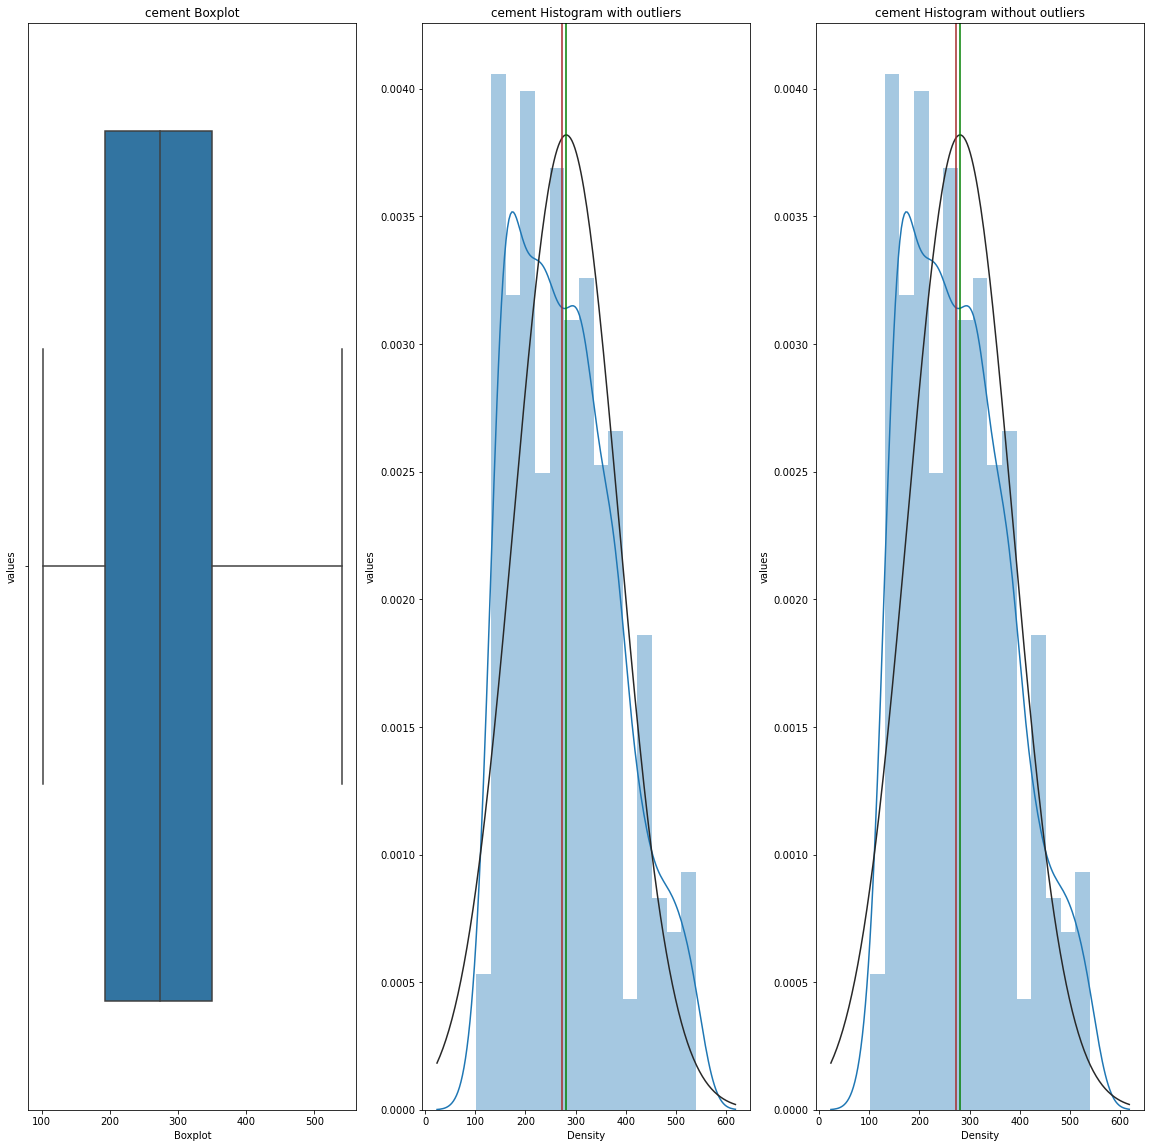

Feature slag have outliers


Total number of outliers in slag are 2


Outlier percentage in slag is 0.0




C:\Users\nitin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
918,239.6,359.4,0.0,185.7,0.0,941.6,664.3,28,39.44
990,239.6,359.4,0.0,185.7,0.0,941.6,664.3,7,25.42


C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


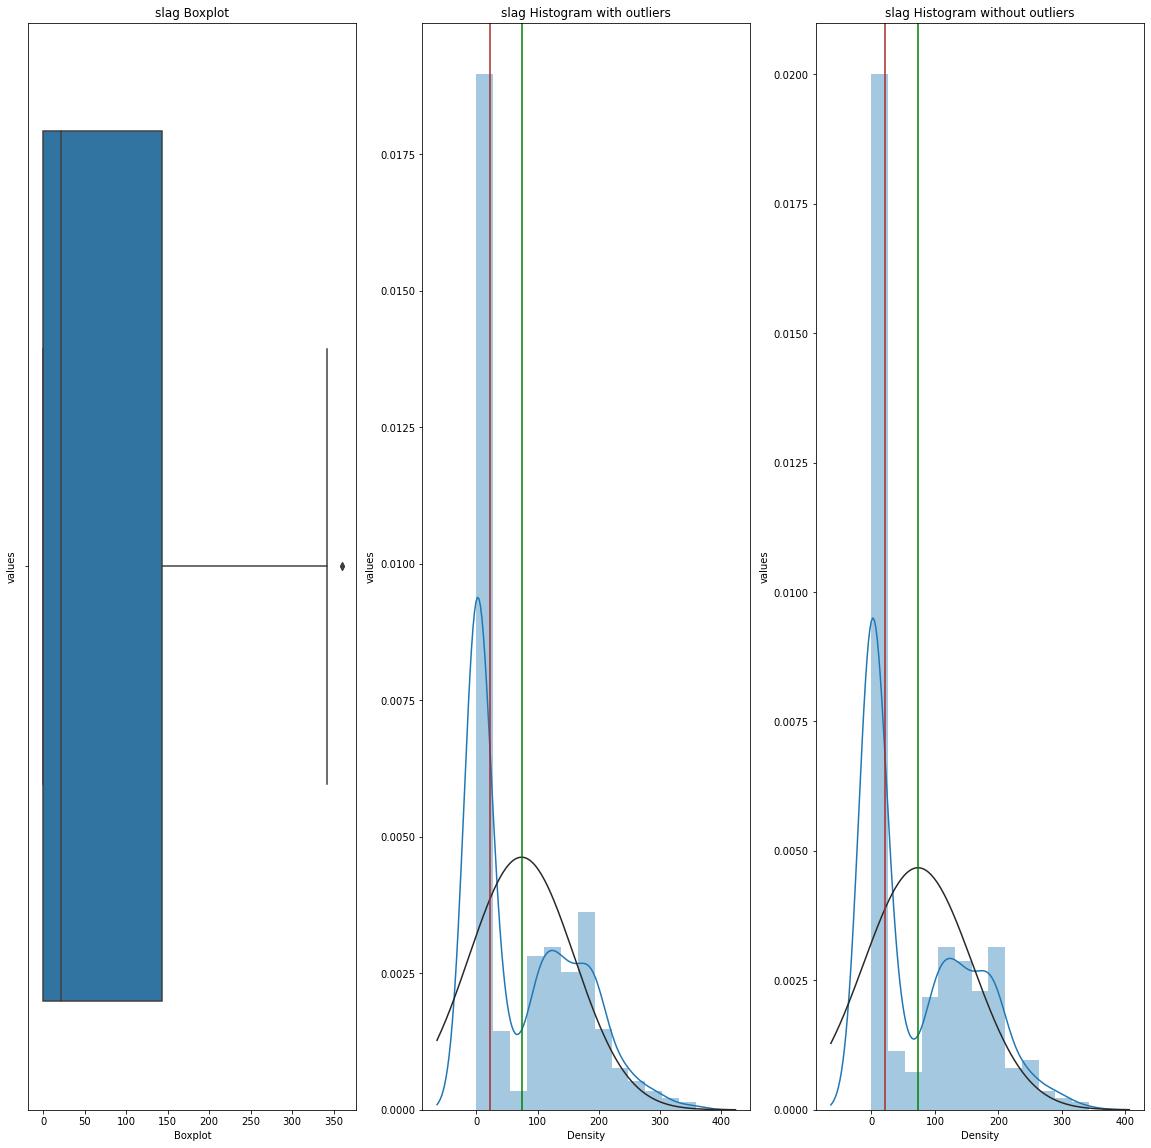

C:\Users\nitin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  w

Feature ash does not have any outliers




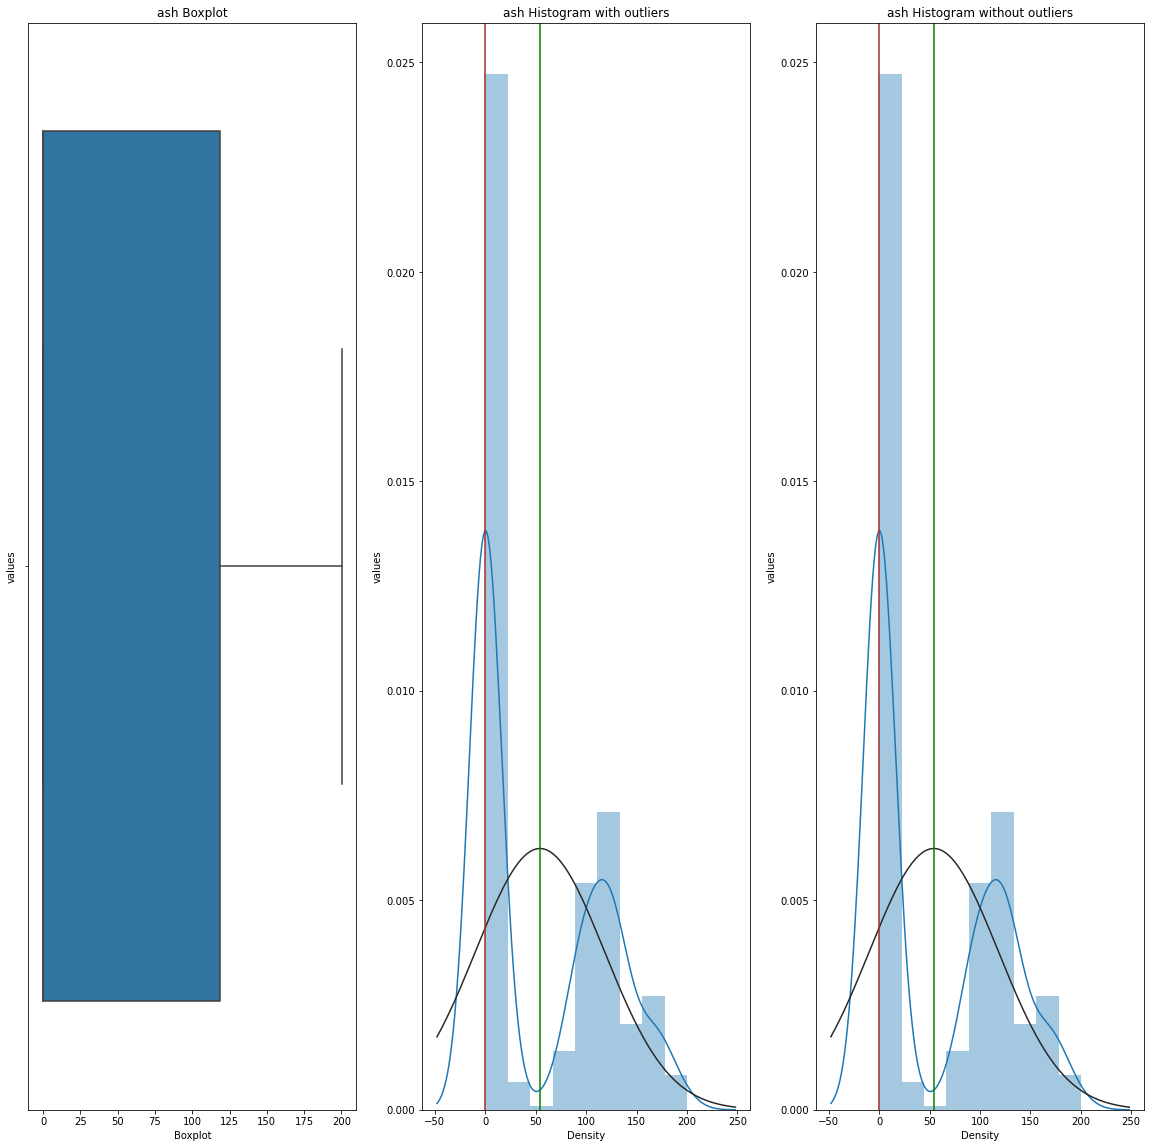

Feature water have outliers


Total number of outliers in water are 9


Outlier percentage in water is 0.01




C:\Users\nitin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
66,237.0,92.0,71.0,247.0,6.0,853.0,695.0,28,28.63
263,236.9,91.7,71.5,246.9,6.0,852.9,695.4,28,28.63
432,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,28,24.24
462,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,100,39.23
587,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,3,7.75
740,140.0,164.0,128.0,237.0,6.0,869.0,656.0,28,35.23
789,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,56,32.85
826,139.7,163.9,127.7,236.7,5.8,868.6,655.6,28,35.23
914,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,14,17.82


C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


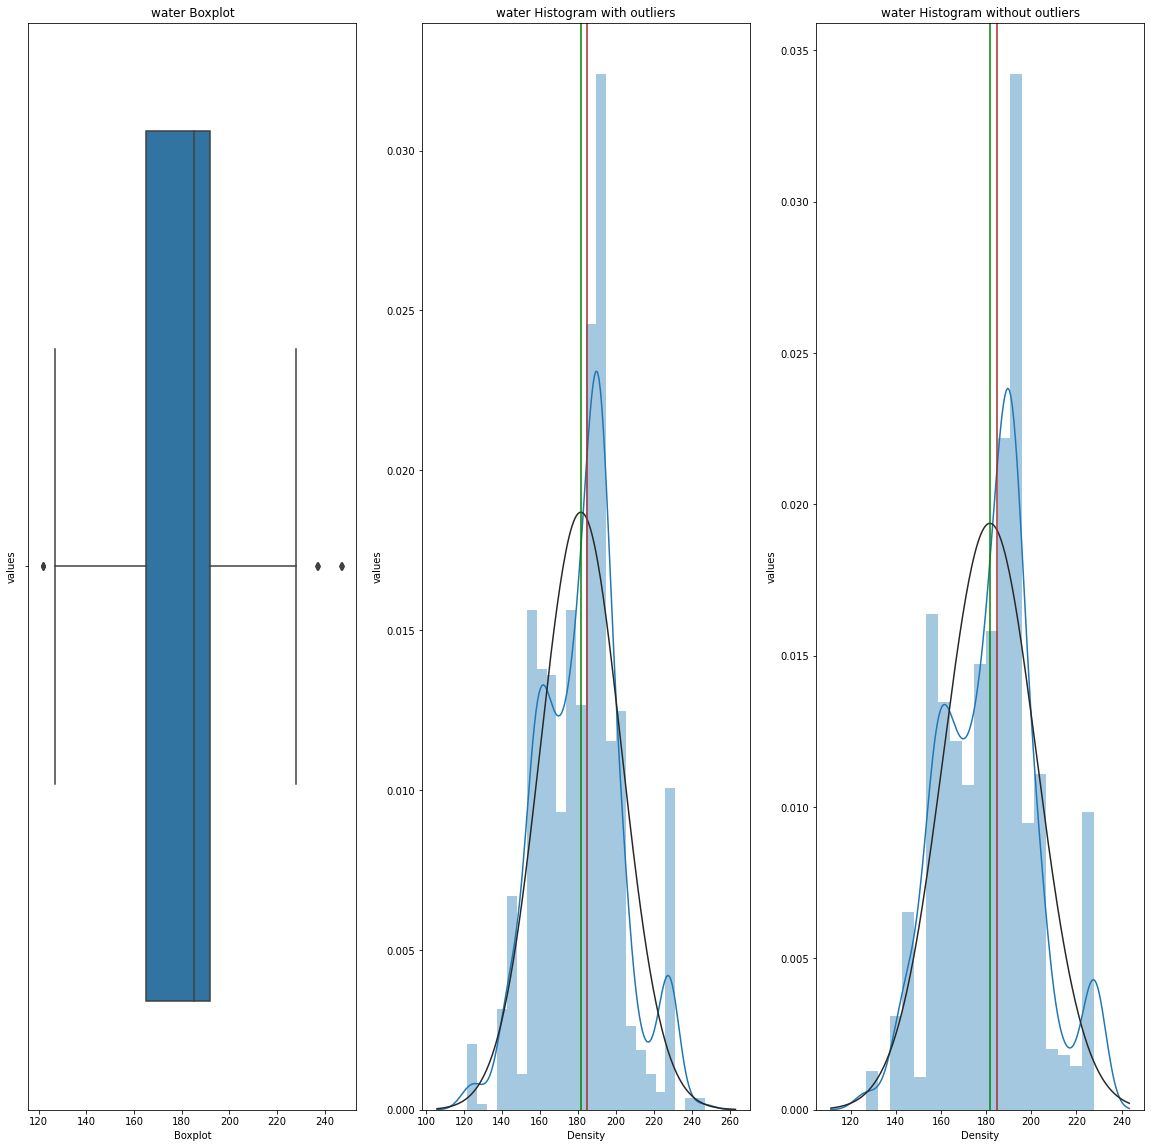

Feature superplastic have outliers


Total number of outliers in superplastic are 10


Outlier percentage in superplastic is 0.01




C:\Users\nitin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
44,531.3,0.0,0.0,141.8,28.2,852.1,893.7,91,59.2
156,531.3,0.0,0.0,141.8,28.2,852.1,893.7,28,56.4
232,469.0,117.2,0.0,137.8,32.2,852.1,840.5,56,69.3
292,469.0,117.2,0.0,137.8,32.2,852.1,840.5,91,70.7
538,531.3,0.0,0.0,141.8,28.2,852.1,893.7,7,46.9
744,469.0,117.2,0.0,137.8,32.2,852.1,840.5,7,54.9
816,469.0,117.2,0.0,137.8,32.2,852.1,840.5,28,66.9
838,531.3,0.0,0.0,141.8,28.2,852.1,893.7,56,58.8
955,469.0,117.2,0.0,137.8,32.2,852.1,840.5,3,40.2
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.3


C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


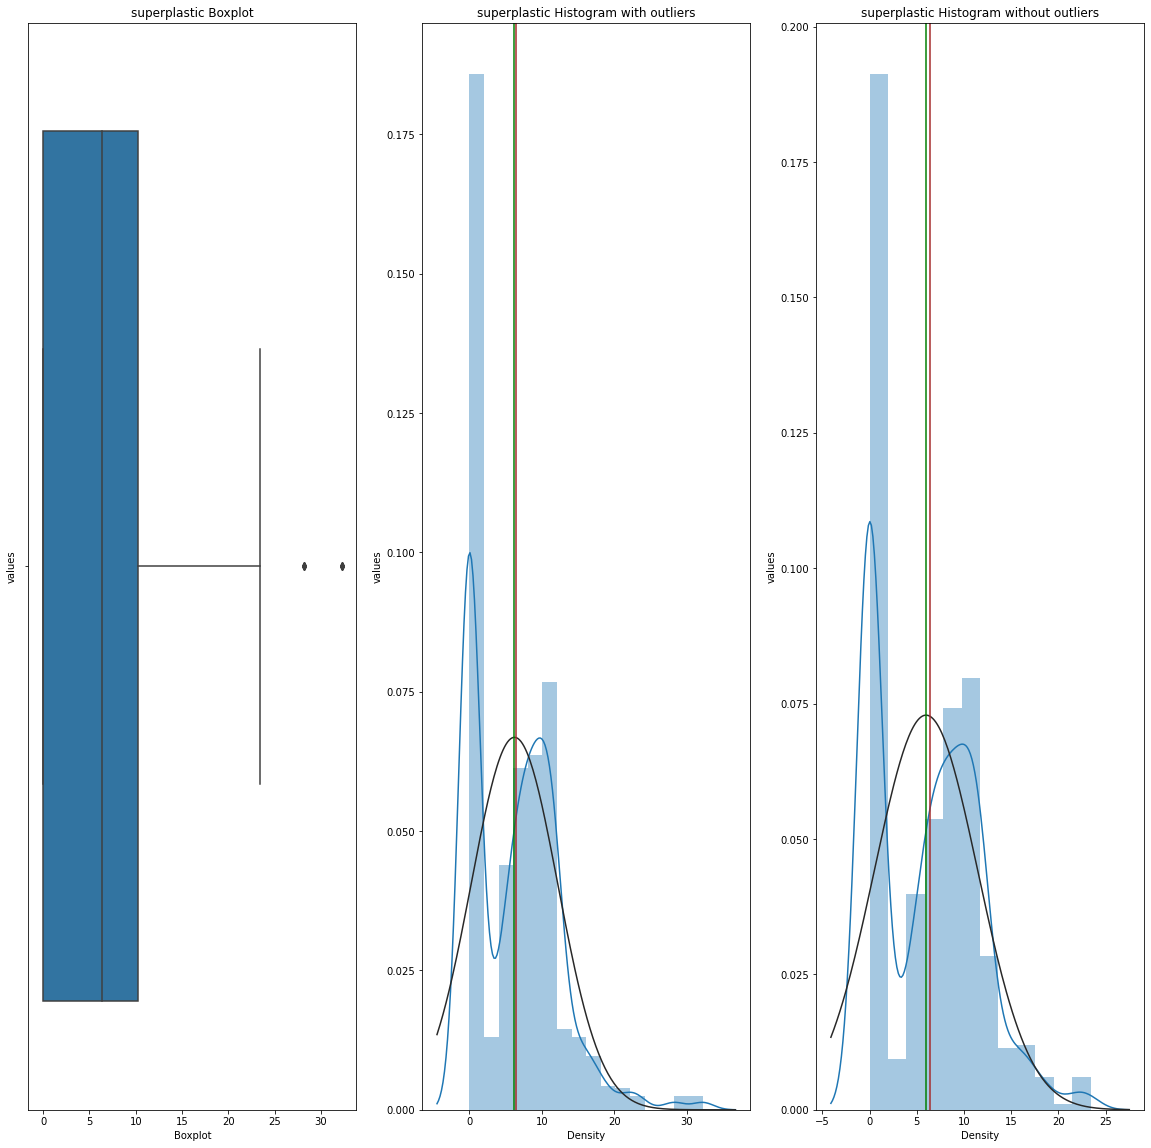

C:\Users\nitin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  w

Feature coarseagg does not have any outliers




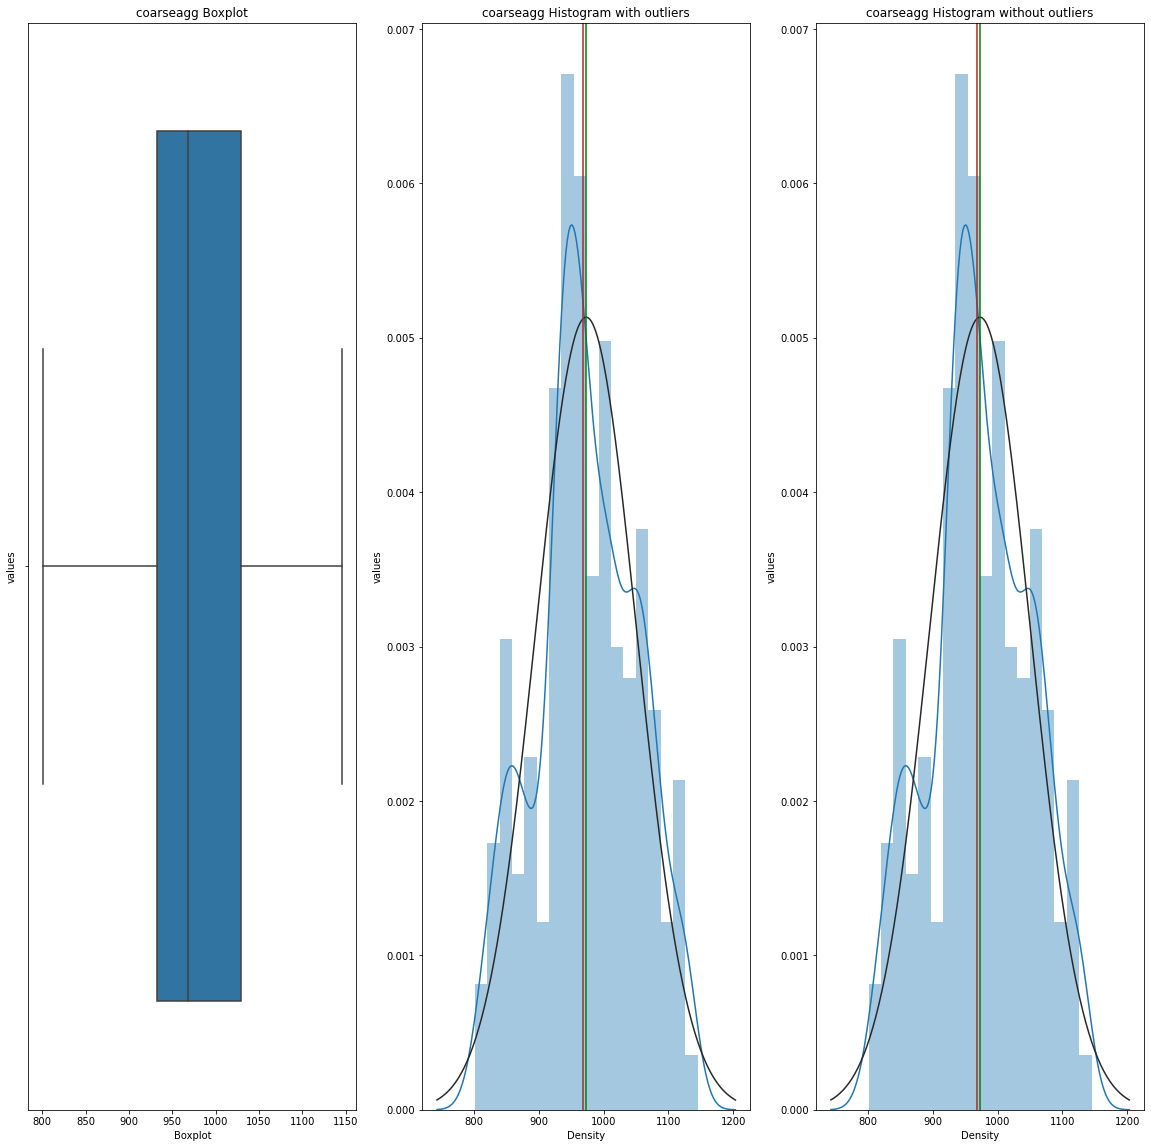

Feature fineagg have outliers


Total number of outliers in fineagg are 5


Outlier percentage in fineagg is 0.0




C:\Users\nitin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
129,375.0,93.8,0.0,126.6,23.4,852.1,992.6,91,62.5
447,375.0,93.8,0.0,126.6,23.4,852.1,992.6,7,45.7
504,375.0,93.8,0.0,126.6,23.4,852.1,992.6,3,29.0
584,375.0,93.8,0.0,126.6,23.4,852.1,992.6,56,60.2
857,375.0,93.8,0.0,126.6,23.4,852.1,992.6,28,56.7


C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


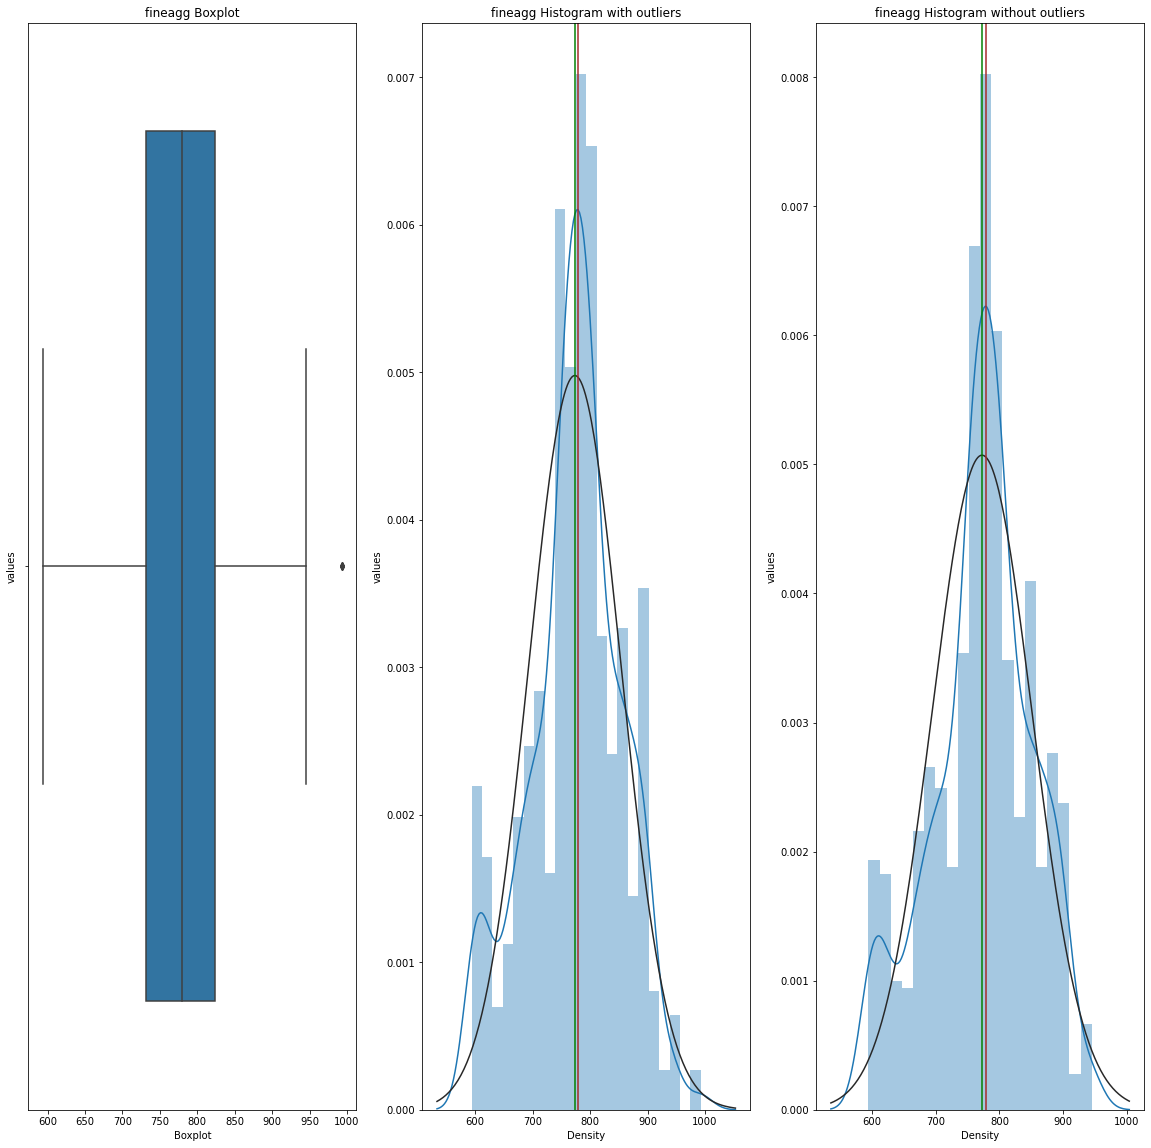

Feature age have outliers


Total number of outliers in age are 59


Outlier percentage in age is 0.06




C:\Users\nitin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
51,331.0,0.0,0.0,192.0,0.0,978.0,825.0,180,39.00
64,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
93,427.5,47.5,0.0,228.0,0.0,932.0,594.0,180,41.84
99,237.5,237.5,0.0,228.0,0.0,932.0,594.0,180,36.25
103,380.0,0.0,0.0,228.0,0.0,932.0,670.0,180,53.10
133,236.0,0.0,0.0,193.0,0.0,968.0,885.0,365,25.08
144,302.0,0.0,0.0,203.0,0.0,974.0,817.0,180,26.74
149,380.0,95.0,0.0,228.0,0.0,932.0,594.0,270,41.15
152,322.0,0.0,0.0,203.0,0.0,974.0,800.0,180,29.59
157,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


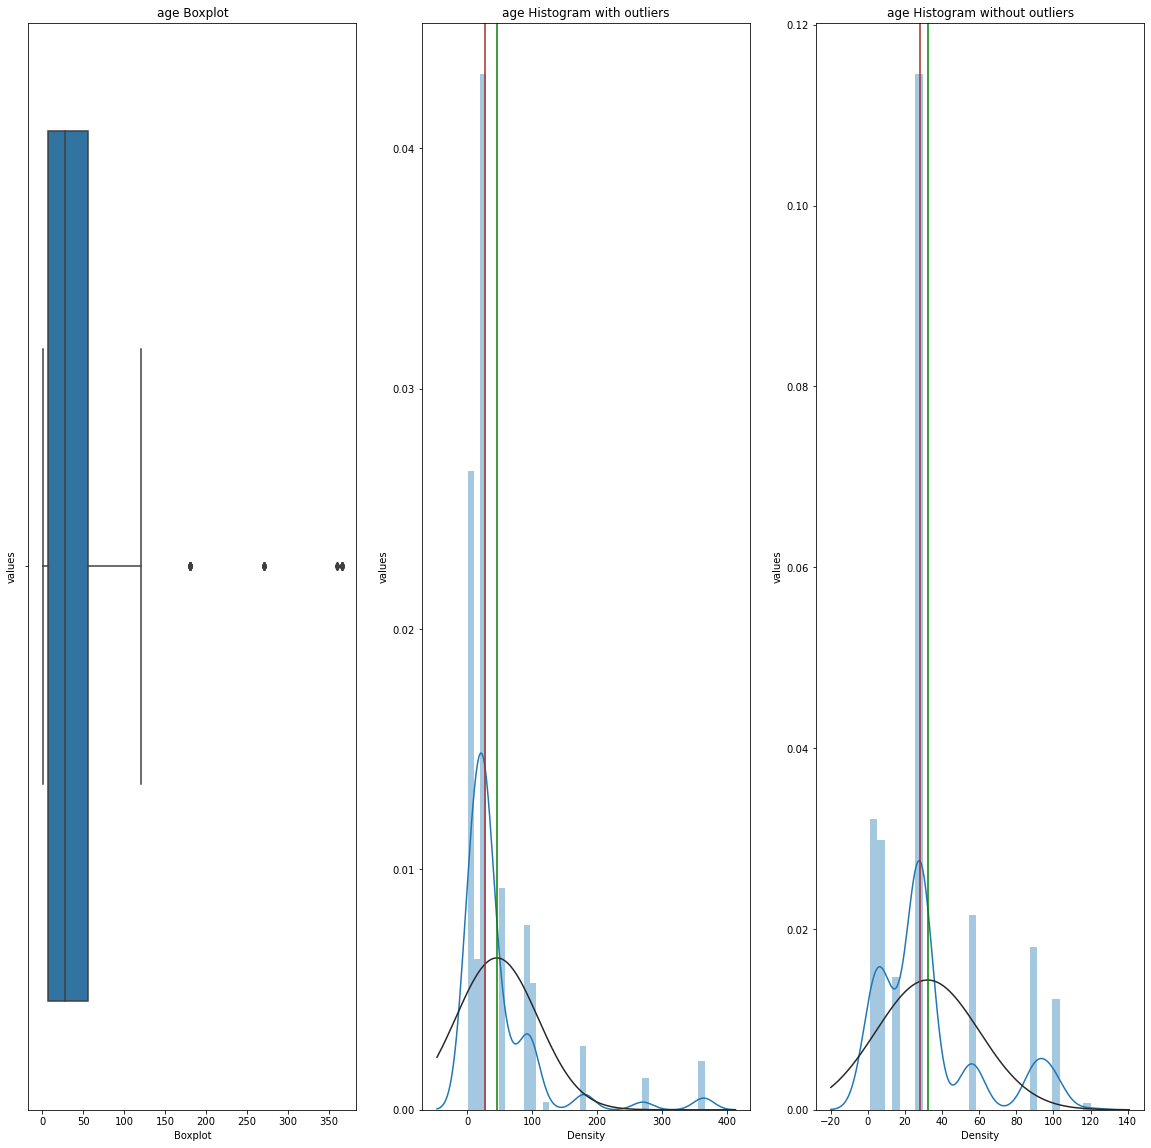

Feature strength have outliers


Total number of outliers in strength are 4


Outlier percentage in strength is 0.0




C:\Users\nitin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
192,315.0,137.0,0.0,145.0,5.9,1130.0,745.0,28.0,81.75
732,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0,79.99
950,389.9,189.0,0.0,145.9,22.0,944.7,755.8,91.0,82.60
1003,323.7,282.8,0.0,183.8,10.3,942.7,659.9,56.0,80.20


C:\Users\nitin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


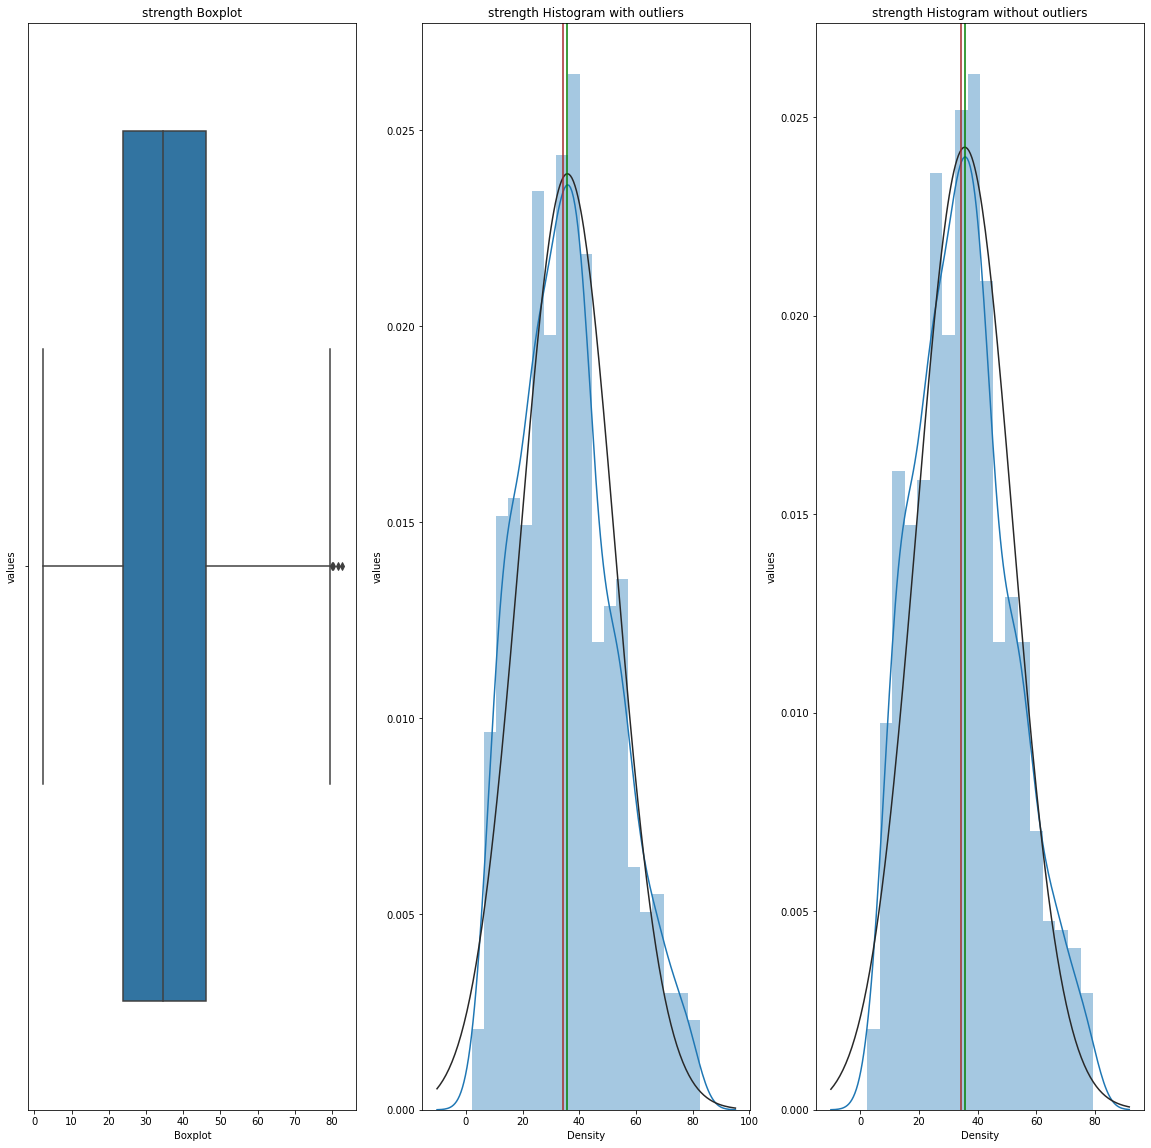

In [11]:
for col in df.columns:
    odt_plot(df,col)

## Multivariate Analysis using Regression

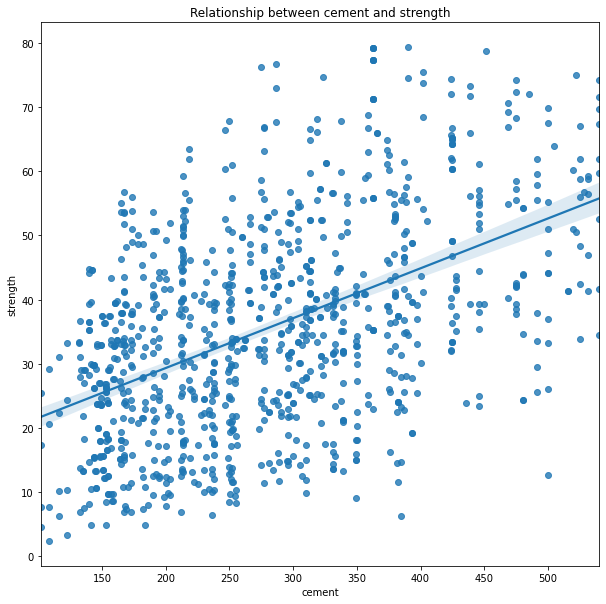

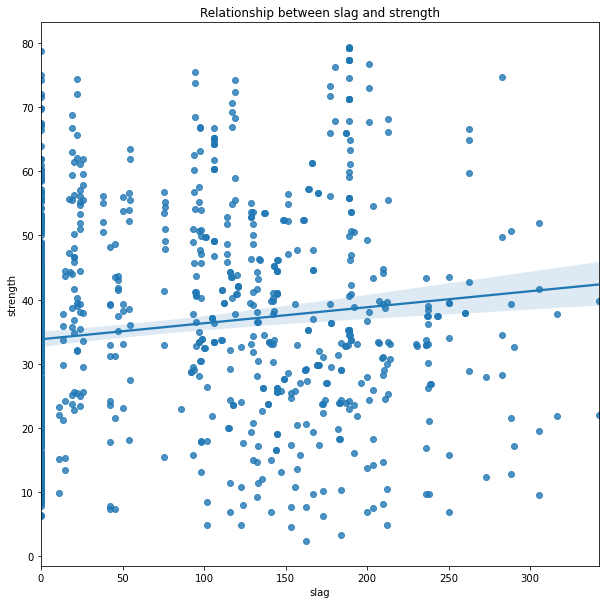

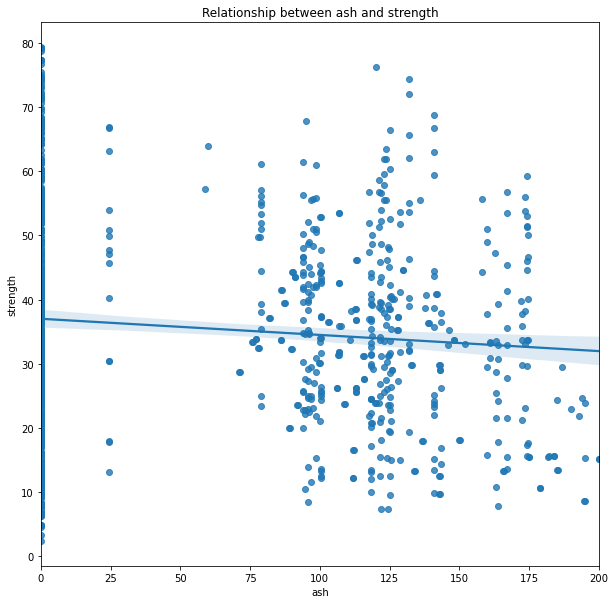

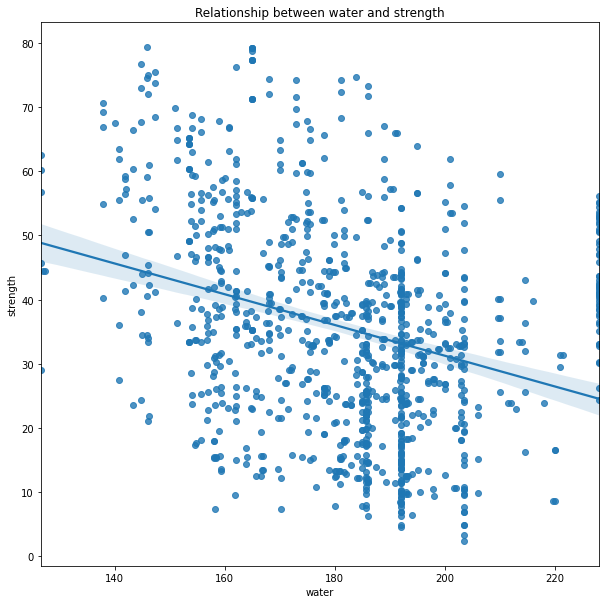

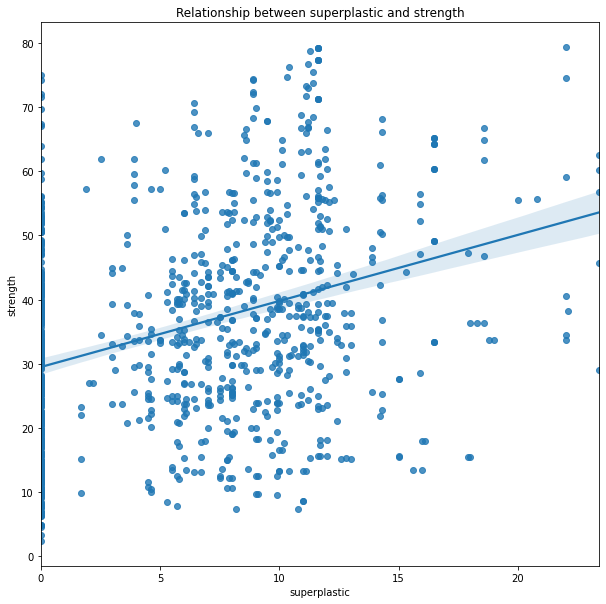

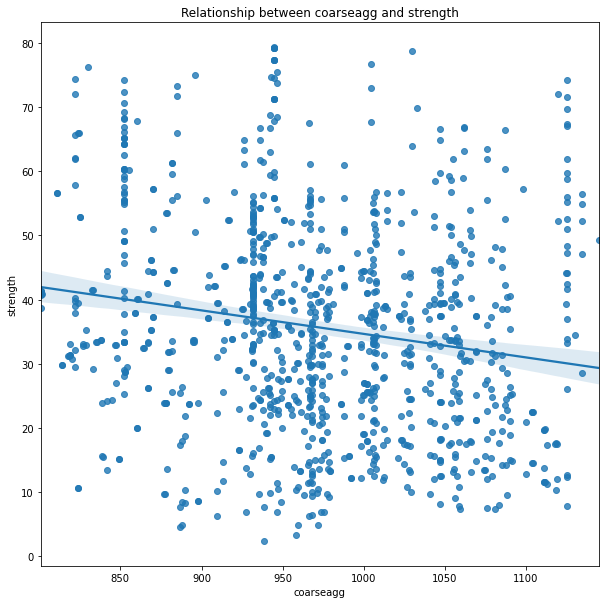

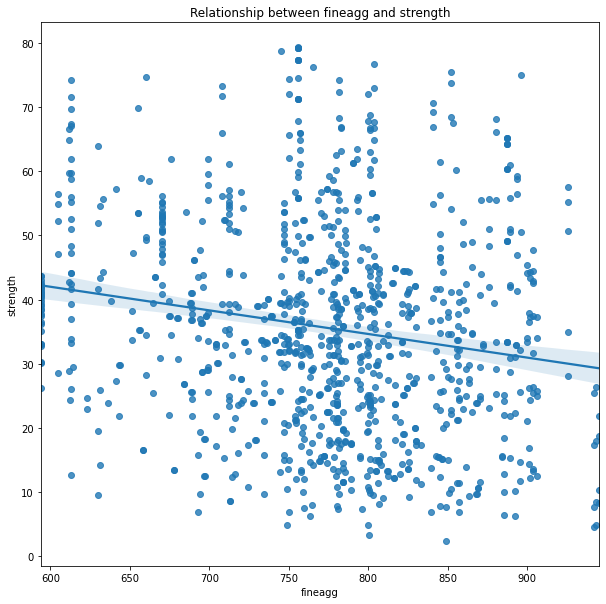

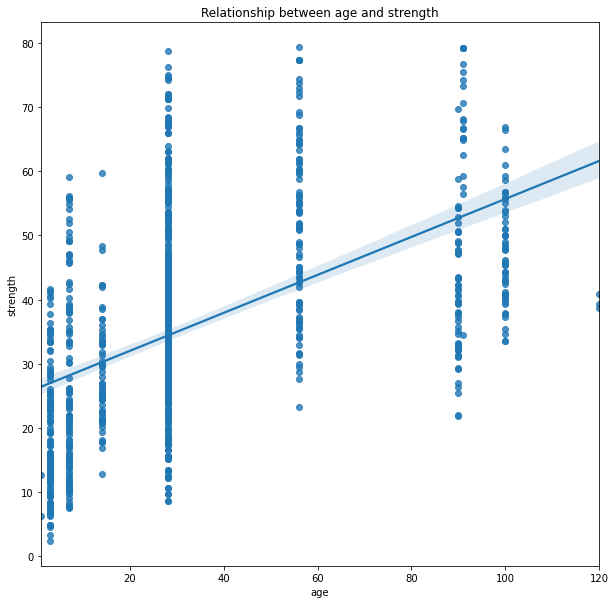

In [12]:
for col in df.columns:
    if col!= 'strength':
        fig,ax1= plt.subplots(figsize=(10,10))
        sns.regplot(x=df[col],y= df['strength'],ax=ax1).set_title(f'Relationship between {col} and strength')
        
    

## Analysis: 1. cement and strength are highly positively correlated, 2. slag and strength are slightly positive correlated. 3. ash and strength are slightly -ve correlated. 4. water and strength are highly -ve correlated. 5. plastic and strength highly +ve correlated. 6. coarseegg and strength slightly -ve correlated.  7. fineagg and strenth -ve correlate. 8. age and strength highly +ve correlated.




# checking Multicolinearity Stage 1
 1) considering greater than 30%

In [13]:
corr= df.corr()

<AxesSubplot:>

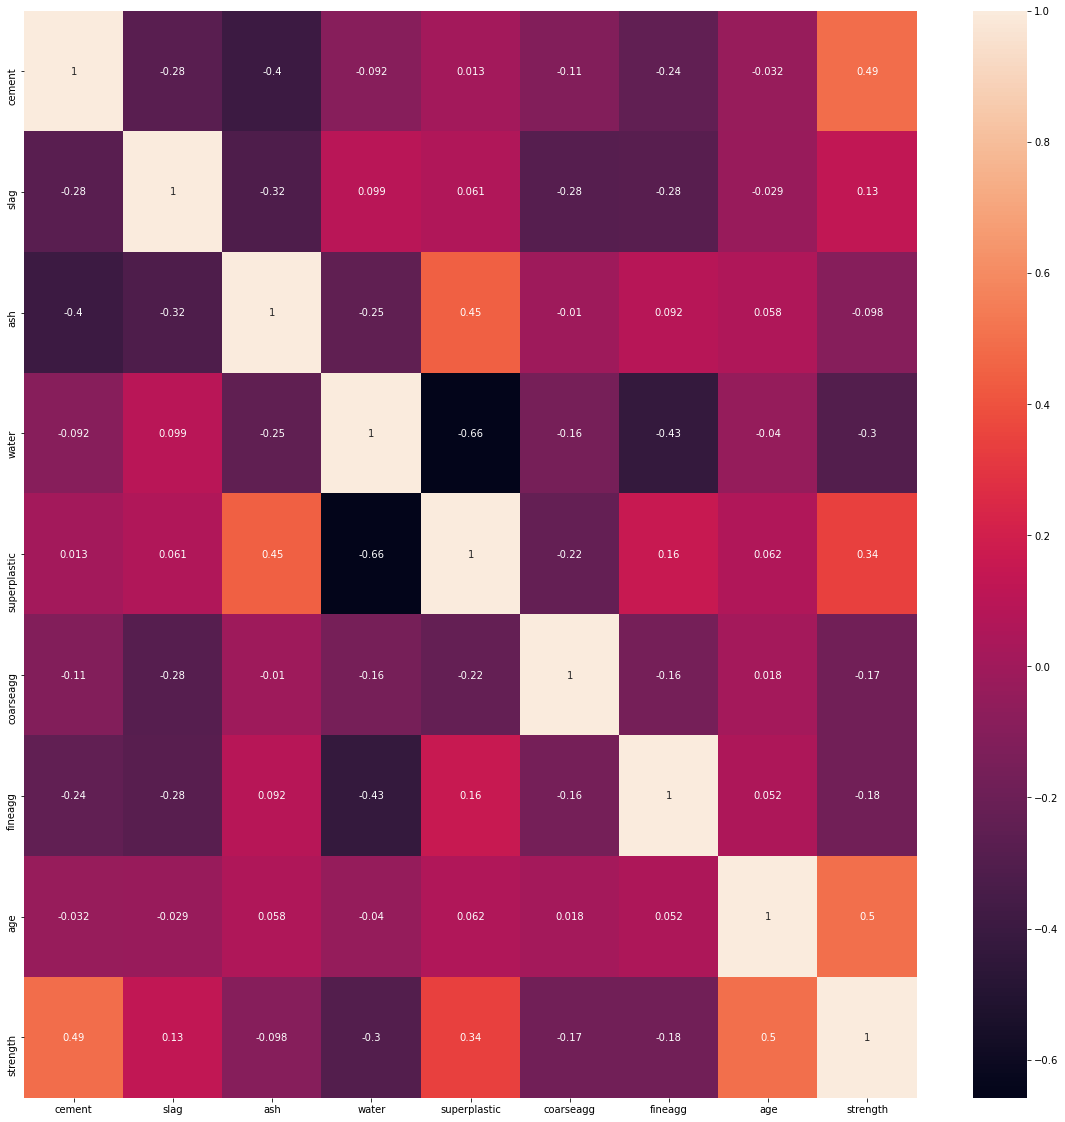

In [14]:
f,ax= plt.subplots(figsize=(20,20))
sns.heatmap(corr,annot=True)

#### multicolinearity between : 1. cement & strength (49%)  2. ash & superplastic(45%)  3. age and strength(50%) 4. ash & cement(-40%) 5. ash and slag(32%) 6. fineagg and water(43%)

## Multicolinearity checking stage 2

In [15]:
#another method to find out Multicolinearity is VIF(Variance Inflation index/Factor)

#vif= 1/(1-r2)
#if vif > 5 then we say that multicolinearity exist

#Steps:
#1. Regress every independent variable with each other and find r2
#2. find out the VIF using above formula

In [16]:
def vif(features):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif= pd.DataFrame()
    vif['vif_factor']= [variance_inflation_factor(features.values,i) for i in range(features.shape[1])]
    vif['features']= features.columns
    
    return vif.sort_values('vif_factor')

In [17]:
vif(df.drop('strength',axis=1))

,vif_factor,features
7,2.368372,age
1,3.342314,slag
2,4.415840,ash
4,5.724145,superplastic
0,14.291158,cement
6,68.664404,fineagg
3,81.963087,water
5,86.938582,coarseagg


## Correlation percentage with the target

In [18]:
def corr_with_target(data,t_col):
    independent_var= data.drop(t_col,axis=1).columns
    corr_result=[]
    for col in independent_var:
        corr_result.append(data[t_col].corr(data[col]))
    result= pd.DataFrame([independent_var,corr_result],index=['independent_var','correlation']).T 
    return result.sort_values('correlation')

In [19]:
corr_with_target(df,'strength')

,independent_var,correlation
3,water,-0.300043
6,fineagg,-0.176113
5,coarseagg,-0.173234
2,ash,-0.097973
1,slag,0.129561
4,superplastic,0.342633
0,cement,0.493518
7,age,0.499711


#### age & cement 49%, superplastic 34% and water 30% correlation

## PCA for multicolinearity

In [20]:
def pca(x):
    
    n_com=len(x.columns)
    
    
    
    # applying std scaler
    from sklearn.preprocessing import StandardScaler
    x= StandardScaler().fit_transform(x)
    
    
    # applying PCA
    
    from sklearn.decomposition import PCA
    
    for i in range(1,n_com):
        pca=PCA(n_components=i)
        p_com=pca.fit_transform(x)
        evr=np.cumsum(pca.explained_variance_ratio_)
        if evr[i-1]>0.9:
            n_components=i
            break    
   

    print("explained variance ratio after pca is ",evr)
    
    # creating a dataframe
    
    col=[]
    for j in range(1,n_components+1):
        col.append("pc"+"_"+str(j))
    
    pca_df=pd.DataFrame(p_com,columns=col)
    return pca_df
        

    

In [21]:
transform_df= pca(df.drop('strength',axis=1))

explained variance ratio after pca is  [0.27112429 0.44666571 0.60914114 0.73584634 0.85926016 0.97264602]


In [22]:
transform_df.head()

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228


In [23]:
transform_df=transform_df.join(df['strength'],how='left')

In [24]:
transform_df.head()

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,strength
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110,29.89
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061,23.51
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045,29.22
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548,45.85
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228,18.29


## Model Building 1. normal 2. cross validation 3. Hyper Parameter model

In [25]:
#1. Normal model 
# Train test split

def train_and_test_split(data,t_col,testsize=0.3):
    x= data.drop(t_col,axis=1)
    y= data[t_col]
    return train_test_split(x,y,test_size=testsize,random_state=0)

In [26]:
#model building function

def build_model(model_name,estimator,data,t_col):
    x_train,x_test,y_train,y_test=train_and_test_split(data,t_col)
    estimator.fit(x_train,y_train)
    y_pred= estimator.predict(x_test)
    rmse= np.sqrt(mean_squared_error(y_test,y_pred))
    r2score= r2_score(y_test,y_pred)
    temp= [model_name,rmse,r2score]
    return temp
    

In [27]:
build_model('LinearRegression',LinearRegression(),transform_df,'strength')

['LinearRegression', 9.26889445776483, 0.6733375978100168]

In [28]:
# building multiple models

def multiple_model(data,t_col):
    col_names= ['model_name','rmse','r2_score']
    result=pd.DataFrame(columns=col_names)
    result.loc[len(result)]=build_model('LinearRegression',LinearRegression(),data,t_col)
    result.loc[len(result)]=build_model('SVR',SVR(),data,t_col)
    result.loc[len(result)]=build_model('Lasso',Lasso(),data,t_col)
    result.loc[len(result)]=build_model('Ridge',Ridge(),data,t_col)
    result.loc[len(result)]=build_model('DecisionTree',DecisionTreeRegressor(),data,t_col)
    result.loc[len(result)]=build_model('Gboost',GradientBoostingRegressor(),data,t_col)
    result.loc[len(result)]=build_model('Adaboost',AdaBoostRegressor(),data,t_col)
    result.loc[len(result)]=build_model('RandomForest',RandomForestRegressor(),data,t_col)
    result.loc[len(result)]=build_model('XGboost',XGBRegressor(),data,t_col)
    result.loc[len(result)]=build_model('KNN',KNeighborsRegressor(),data,t_col)
    
    
    return result


    
        
    
    
    
    

In [29]:
multiple_model(transform_df,'strength')

,model_name,rmse,r2_score
0,LinearRegression,9.268894,0.673338
1,SVR,9.051841,0.688458
2,Lasso,9.635047,0.647019
3,Ridge,9.270519,0.673223
4,DecisionTree,7.823491,0.767274
5,Gboost,6.649456,0.831882
6,Adaboost,8.674600,0.713884
7,RandomForest,6.199322,0.853873
8,XGboost,5.776115,0.873143
9,KNN,7.813128,0.767890


In [30]:
# Cross Validation


def k_fold_cv(x,y,fold=10):
    
    score_lr= cross_val_score(LinearRegression(),x,y,cv=fold)
    score_svr= cross_val_score(SVR(),x,y,cv=fold)
    score_rf= cross_val_score(RandomForestRegressor(),x,y,cv=fold)
    score_dt= cross_val_score(DecisionTreeRegressor(),x,y,cv=fold)
    score_knn= cross_val_score(KNeighborsRegressor(),x,y,cv=fold)
    score_lasso= cross_val_score(Lasso(),x,y,cv=fold)
    score_ridge= cross_val_score(Ridge(),x,y,cv=fold)
    score_ada= cross_val_score(AdaBoostRegressor(),x,y,cv=fold)
    score_gb= cross_val_score(GradientBoostingRegressor(),x,y,cv=fold)
    score_xgb= cross_val_score(XGBRegressor(),x,y,cv=fold)
    
    
    model_names= ['LinearRegression','SVR','RandomForest','DecisionTree','KNN','Lasso','Ridge',"adaboost",'Gboost','Xgboost']
    score=[score_lr,score_svr,score_rf,score_dt,score_knn,score_lasso,score_ridge,score_ada,score_gb,score_xgb]
    
    result=[]
    
    for i in range(0,len(model_names)):
        score_mean= np.mean(score[i])
        score_std= np.std(score[i])
        m_names= model_names[i]
        temp= [m_names,score_mean,score_std]
        
        result.append(temp)
        
        
    kfold_df= pd.DataFrame(result,columns=['model_names','score_mean','score_std'])
    return kfold_df
        
    
    
    

In [31]:
k_fold_cv(transform_df.drop('strength',axis=1),transform_df['strength'])

,model_names,score_mean,score_std
0,LinearRegression,0.663928,0.059476
1,SVR,0.703117,0.042765
2,RandomForest,0.867250,0.032443
3,DecisionTree,0.763995,0.054731
4,KNN,0.767691,0.055604
5,Lasso,0.649837,0.049887
6,Ridge,0.663935,0.059437
7,adaboost,0.732100,0.035457
8,Gboost,0.829240,0.050227
9,Xgboost,0.873262,0.036061


### Hyper parameter tuning

In [32]:
def tuning(x,y,kfold=10):
    
    #parameter grid
    
    param_las={'alpha':[1e-15,1e-13,1e-11,1e-9,1e-7,1e-5,1e-3,1e-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50,60,70,80,90,100]}
    param_ridge= {'alpha':[1e-15,1e-13,1e-11,1e-9,1e-7,1e-5,1e-3,1e-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50,60,70,80,90,100]}
    param_knn= {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]}
   # param_tree={'criterion':['gini','entropy']}
    param_gboost={'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_ada= {'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_xg={'alpha':[0,1],'gamma':[10,20,30,40,50,60,70,80,90,100],'reg_lambda':[0,1]}
    
    # hyper parameter tuning
    
    tune_las= GridSearchCV(Lasso(),param_las,cv=kfold)
    tune_ridge= GridSearchCV(Ridge(),param_ridge,cv=kfold)
    tune_knn= GridSearchCV(KNeighborsRegressor(),param_knn,cv=kfold)
    #tune_tree= GridSearchCV(DecisionTreeRegressor(),param_tree,cv=kfold)
    tune_gboost= GridSearchCV(GradientBoostingRegressor(),param_gboost,cv=kfold)
    tune_ada= GridSearchCV(AdaBoostRegressor(),param_ada,cv=kfold)
    tune_xg= GridSearchCV(XGBRegressor(),param_xg,cv=kfold)
    
    
    # fitting x & y
    
    tune_las.fit(x,y)
    tune_ridge.fit(x,y)
    tune_knn.fit(x,y)
    #tune_tree.fit(x,y)
    tune_gboost.fit(x,y)
    tune_ada.fit(x,y)
    tune_xg.fit(x,y)
    
    
    tune=[tune_las,tune_ridge,tune_knn,tune_gboost,tune_ada,tune_xg]
    models=['Lasso','Ridge','KNN','GBoost','AdaBoost','XGBoost']
    
    for i in range(0,len(tune)):
        print('model',models[i])
        print('best_parameters',tune[i].best_params_)
        
            
    

In [33]:
tuning(transform_df.drop('strength',axis=1),transform_df['strength'])

C:\Users\nitin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20791.168080915853, tolerance: 25.892099378176912
  model = cd_fast.enet_coordinate_descent(
C:\Users\nitin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16198.786268091302, tolerance: 25.03670756417476
  model = cd_fast.enet_coordinate_descent(
C:\Users\nitin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21170.230240358032, tolerance: 24.58893286581446
  model = cd_fast.enet_coordinate_descent(
C:\Users\nitin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\Users\nitin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\nitin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nitin\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\Users\nitin\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 270, in _check_params
    raise ValueError("alpha must be in (0.0, 1.0) but "
ValueError: alpha must be in (0.0, 1.0) but was 1

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\nitin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these par

model Lasso
best_parameters {'alpha': 0.1}
model Ridge
best_parameters {'alpha': 6}
model KNN
best_parameters {'n_neighbors': 4}
model GBoost
best_parameters {'alpha': 0.2}
model AdaBoost
best_parameters {'learning_rate': 1}
model XGBoost
best_parameters {'alpha': 1, 'gamma': 10, 'reg_lambda': 0}


## model with cross validation and hyperparametrically tunned

In [34]:
def k_fold_cv_with_hyperparameter_tunned(x,y,fold=10):
    
    score_lr= cross_val_score(LinearRegression(),x,y,cv=fold)
    score_svr= cross_val_score(SVR(),x,y,cv=fold)
    score_rf= cross_val_score(RandomForestRegressor(),x,y,cv=fold)
    score_dt= cross_val_score(DecisionTreeRegressor(),x,y,cv=fold)
    score_knn= cross_val_score(KNeighborsRegressor(n_neighbors=4),x,y,cv=fold)
    score_lasso= cross_val_score(Lasso(alpha=0.1),x,y,cv=fold)
    score_ridge= cross_val_score(Ridge(alpha=6),x,y,cv=fold)
    score_ada= cross_val_score(AdaBoostRegressor(learning_rate=0.8),x,y,cv=fold)
    score_gb= cross_val_score(GradientBoostingRegressor(alpha=0.1),x,y,cv=fold)
    score_xgb= cross_val_score(XGBRegressor(alpha=1,gamma=10,reg_lambda=0),x,y,cv=fold)
    
    
    model_names= ['LinearRegression','SVR','RandomForest','DecisionTree','KNN','Lasso','Ridge',"adaboost",'Gboost','Xgboost']
    score=[score_lr,score_svr,score_rf,score_dt,score_knn,score_lasso,score_ridge,score_ada,score_gb,score_xgb]
    
    result=[]
    
    for i in range(0,len(model_names)):
        score_mean= np.mean(score[i])
        score_std= np.std(score[i])
        m_names= model_names[i]
        temp= [m_names,score_mean,score_std]
        
        result.append(temp)
        
        
    kfold_df= pd.DataFrame(result,columns=['model_names','score_mean','score_std'])
    return kfold_df
        
    
    
    

In [35]:
k_fold_cv_with_hyperparameter_tunned(transform_df.drop('strength',axis=1),transform_df['strength'])

,model_names,score_mean,score_std
0,LinearRegression,0.663928,0.059476
1,SVR,0.703117,0.042765
2,RandomForest,0.867101,0.031935
3,DecisionTree,0.762181,0.067498
4,KNN,0.771057,0.054397
5,Lasso,0.664143,0.058426
6,Ridge,0.663951,0.059242
7,adaboost,0.729263,0.038492
8,Gboost,0.828858,0.050346
9,Xgboost,0.866932,0.036608


In [36]:
#random forest performs best low stddeviation and high mean score

In [37]:
## Using Clustering checking accuracy is imporoved or not
from sklearn.cluster import KMeans

In [38]:
labels=KMeans(n_clusters=2,random_state=50)

In [39]:
cluster=labels.fit_predict(df.drop("strength",axis=1))

<AxesSubplot:xlabel='cement', ylabel='strength'>

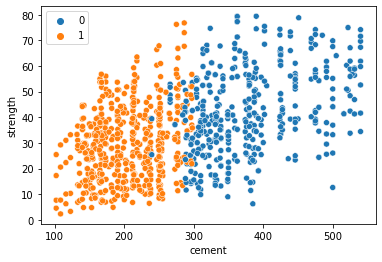

In [40]:
sns.scatterplot(x=df["cement"],y=df["strength"],hue=cluster)

In [41]:
def clustering(x,t_col,cluster):
    column= list(set(list(x.columns))- set(df['strength']))
    r= int(len(column)/2)
    if r%2==0:
        r=r
    else:
        r=r+1
    
    
    
    f,ax=plt.subplots(r,2,figsize=(15,15))
    a=0
    for row in range(0,r):
        for col in range(0,2):
            if a!= len(column):
                ax[row][col].scatter(x[t_col],x[column[a]],c=cluster)
                
                ax[row][col].set_xlabel(t_col)
                ax[row][col].set_ylabel(column[a])
                a=a+1


In [42]:
x=df.drop("strength",axis=1)

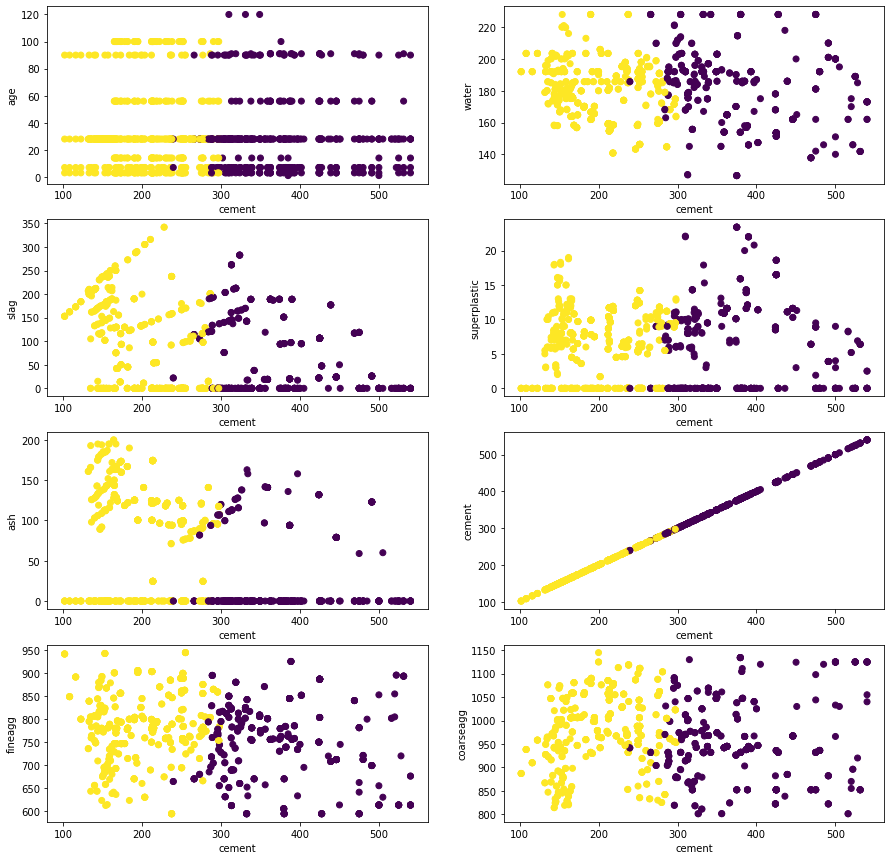

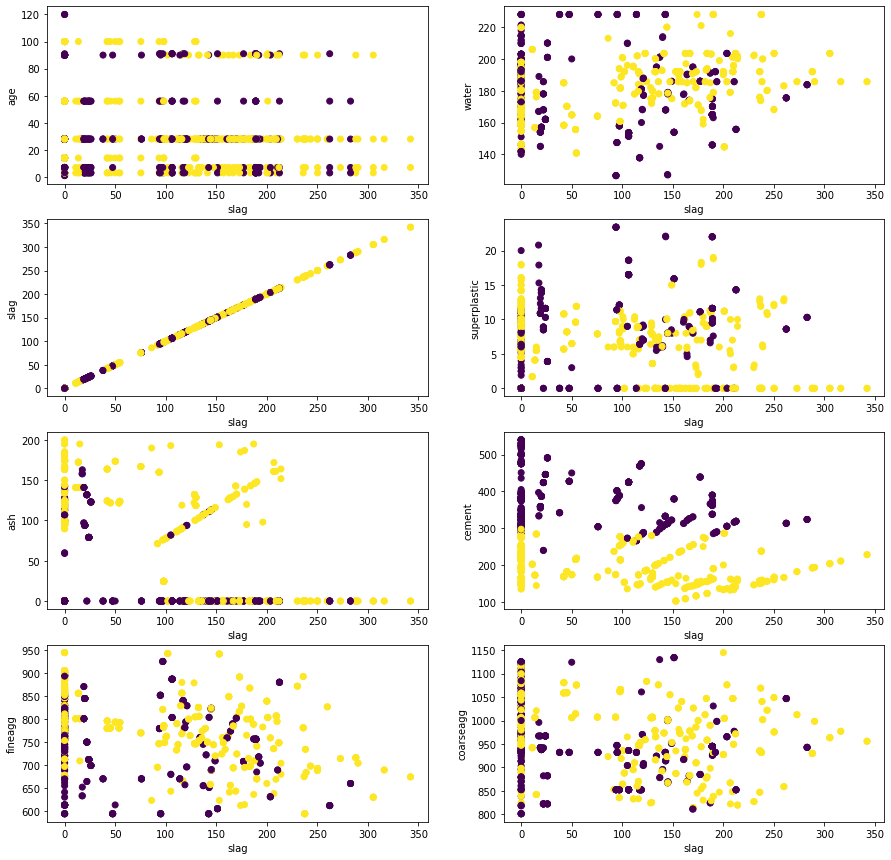

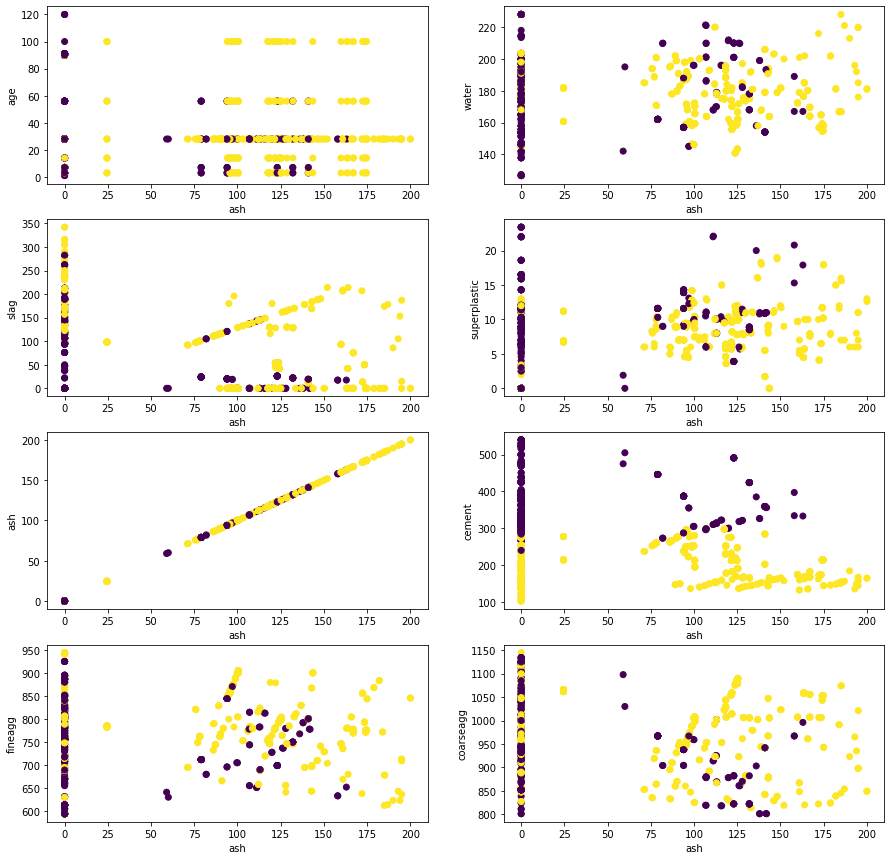

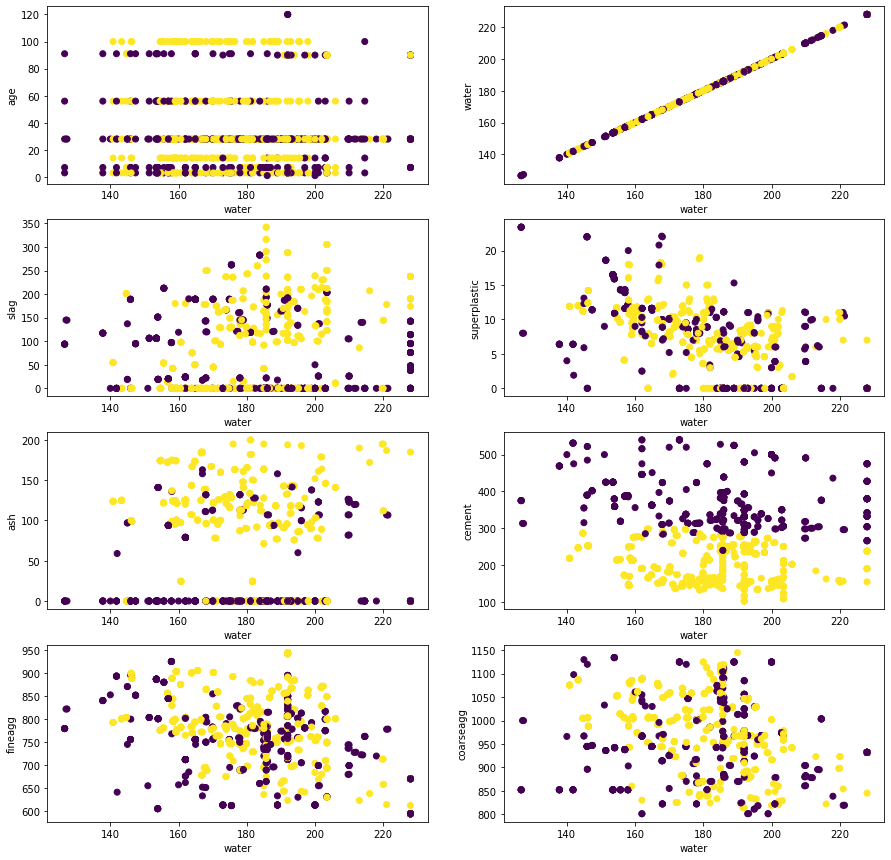

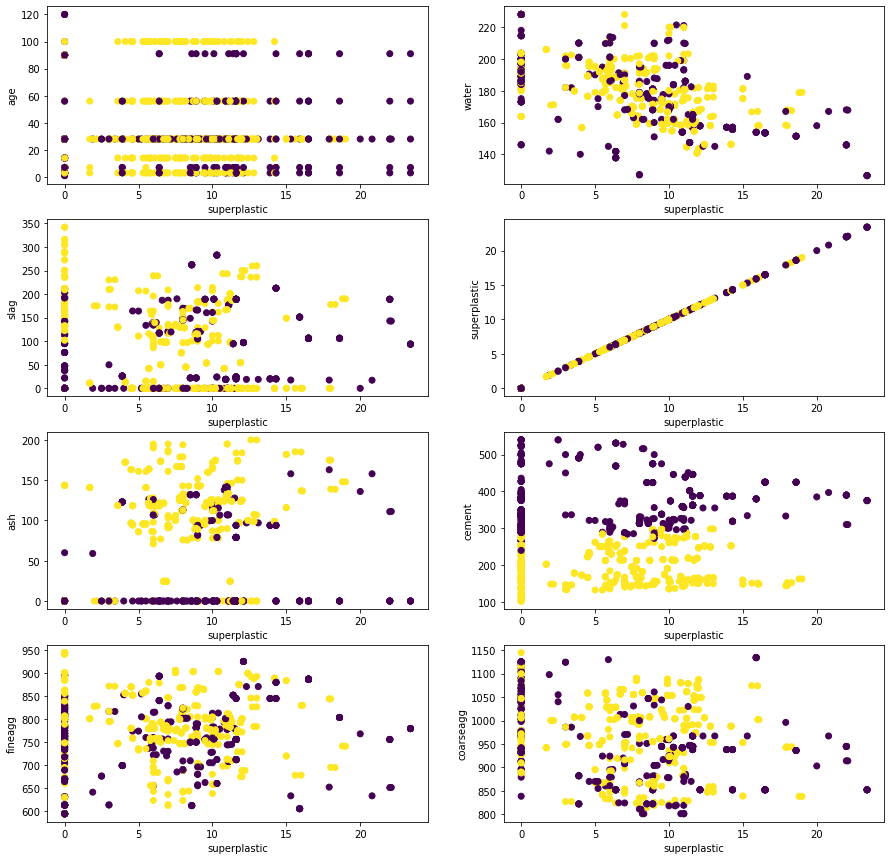

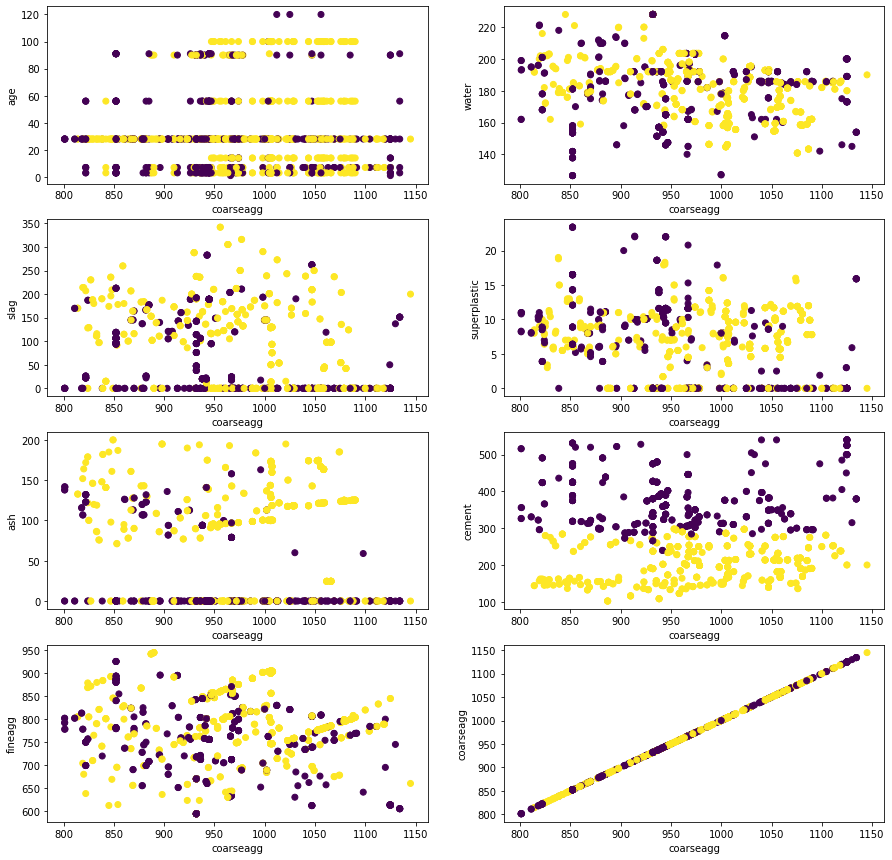

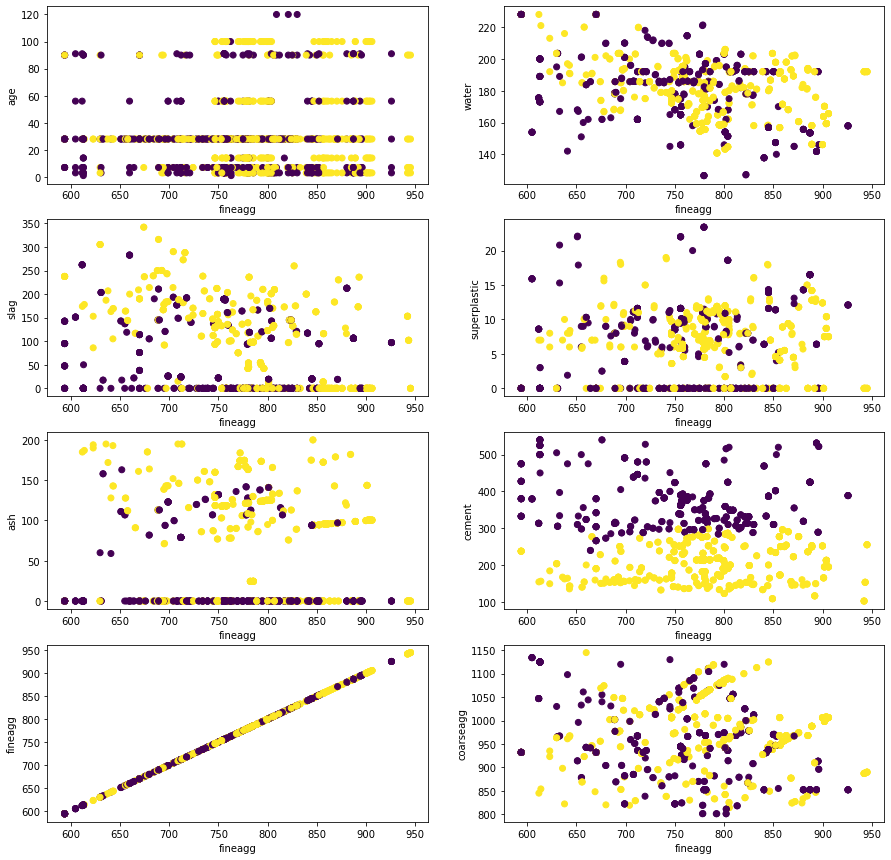

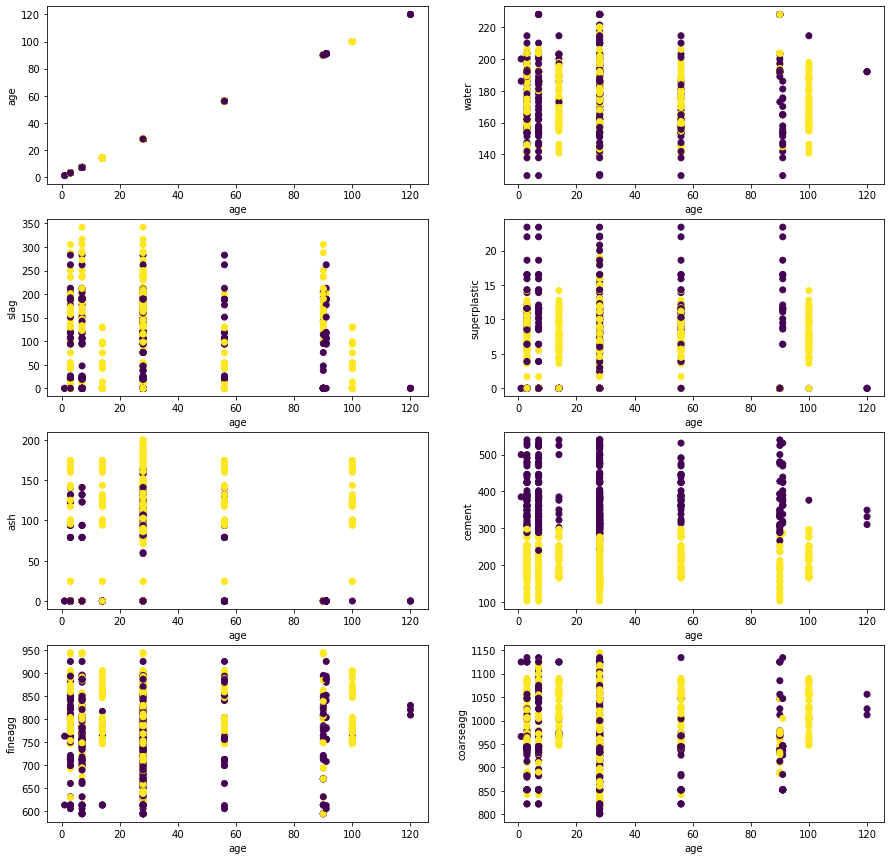

In [43]:
for col in x.columns:
    clustering(x,col,cluster)

In [44]:
#cement cluster with superplastic,ash,slag,water,
#cement is formimg cluster with all the features

In [45]:
new_df=df.join(pd.DataFrame(cluster,columns=["cluster"]),how="left")

In [46]:
new_f=new_df.groupby("cluster")["cement"].agg(["mean","median"])

In [47]:
new_f.head()

,mean,median
cluster,,
0,376.731317,362.6
1,203.132804,202.0


In [48]:
new_df= new_df.merge(new_f,on= 'cluster',how='left')

In [49]:
new_df

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,cluster,mean,median
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28.0,29.89,1,203.132804,202.0
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14.0,23.51,1,203.132804,202.0
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28.0,29.22,1,203.132804,202.0
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28.0,45.85,0,376.731317,362.6
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28.0,18.29,1,203.132804,202.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28.0,13.29,1,203.132804,202.0
1026,531.3,0.0,0.0,141.8,6.4,852.1,893.7,3.0,41.30,0,376.731317,362.6
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28.0,44.28,1,203.132804,202.0
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28.0,55.06,0,376.731317,362.6


In [50]:
x= new_df.drop('strength',axis=1)
y=new_df['strength']

In [51]:
multiple_model(new_df,'strength')

,model_name,rmse,r2_score
0,LinearRegression,8.894347,0.699204
1,SVR,14.035678,0.250951
2,Lasso,8.902736,0.698637
3,Ridge,8.894349,0.699204
4,DecisionTree,6.444285,0.842096
5,Gboost,5.299049,0.893232
6,Adaboost,8.531129,0.723270
7,RandomForest,5.339263,0.891606
8,XGboost,4.884051,0.909301
9,KNN,8.961329,0.694657


In [52]:
k_fold_cv_with_hyperparameter_tunned(x,y)

,model_names,score_mean,score_std
0,LinearRegression,0.686384,0.062380
1,SVR,0.238550,0.045211
2,RandomForest,0.888701,0.035607
3,DecisionTree,0.830936,0.056408
4,KNN,0.681656,0.080129
5,Lasso,0.686641,0.062319
6,Ridge,0.686641,0.062315
7,adaboost,0.735269,0.035169
8,Gboost,0.875714,0.045134
9,Xgboost,0.893114,0.040223


## understanding feature importants using xgboost

In [53]:
x_train,x_test,y_train,y_test=train_and_test_split(new_df.drop("cluster",axis=1),"strength")

In [54]:
xgb=XGBRegressor()

In [55]:
xgb.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

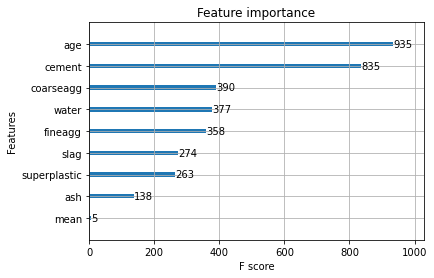

In [56]:
xgboost.plot_importance(xgb)

In [57]:
new_df1=new_df[['age','cement','coarseagg','water','fineagg','superplastic','strength']]

In [58]:
new_df1.head()

,age,cement,coarseagg,water,fineagg,superplastic,strength
0,28.0,141.3,971.8,203.5,748.5,0.0,29.89
1,14.0,168.9,1080.8,158.3,796.2,10.8,23.51
2,28.0,250.0,956.9,187.4,861.2,5.5,29.22
3,28.0,266.0,932.0,228.0,670.0,0.0,45.85
4,28.0,154.8,1047.4,193.3,696.7,9.1,18.29


## Building Learning curve analysis

In [61]:
def gernerate_learning_curve(model_name,estimator,x,y):
    train_size,train_score,test_score=learning_curve(estimator=estimator,X=x,y=y,cv=10)
    train_score_mean=np.mean(train_score,axis=1)
    test_score_mean=np.mean(test_score,axis=1)
    plt.plot(train_size,train_score_mean,c='blue')
    plt.plot(train_size,test_score_mean,c='green')
    plt.xlabel("Samples")
    plt.ylabel("Accuracies")
    plt.title("Learning curve for "+model_name)
    plt.legend(('training accuracy','testing accuracy'))
    

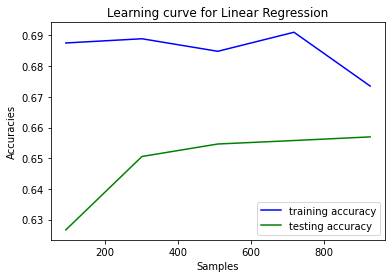

In [62]:
gernerate_learning_curve("Linear Regression",LinearRegression(),new_df1.drop("strength",axis=1),new_df1['strength'])